In [1]:
import pythtb as tb
import yeet_pythtb as ytb
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as alg
import random,time
from numba import njit,typeof,generated_jit
from numba.types import float64,complex128,int64

C:\Users\mikel\Documents\GitHub\custom_pythtb\yeet_pythtb.py:115: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if lat is 'unit' or lat is None:
C:\Users\mikel\Documents\GitHub\custom_pythtb\yeet_pythtb.py:135: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if orb is 'bravais' or orb is None:


In [2]:
im = 1j

sx = np.array([[0.,1.],[1.,0.]])
sy = np.array([[0.,-im],[im,0.]])
sz = np.array([[1.,0.],[0.,1.]])
s0 = np.eye(2)

sqrt3 = np.sqrt(3)
sqrt2 = np.sqrt(2)

In [3]:
def monolayer(soc,nspin=2,Brinv=False,Brmirror=False,allSOC=False):
    
    #Lattice constants
    a = 3.495
    b = sqrt3 * a
    c = 14.028
    #Rectangular unit cell
    basis = np.array([[a,0,0],[0,b,0],[0,0,c]],dtype='float32')
    
    #Atomic positions
    dB =  np.array([    0.25 ,  0.1533 ,  0.1405 ],dtype='float32') #d orbital
    dA =  np.array([    0.75 ,  0.8418 ,  0.1236 ],dtype='float32') #d orbital
    pB =  np.array([    0.25 ,  0.6216 ,  0.1651 ],dtype='float32') #px orbital
    pA =  np.array([    0.75 ,  0.3776 ,  0.0952 ],dtype='float32') #px orbital
    
    orbitals = [dB,dA,pB,pA]
    model = tb.tb_model(2,3,lat=basis,orb=orbitals,per=[0,1],nspin=nspin)
    
    #On-site energies
    mud = 0.29 + 0.15
    mup = -2.04 + 0.15
    model.set_onsite([mud,mud,mup,mup])
    
    #Hopping parameters
    #Original model (see Akhmerov)
    t01 =   0.53                  #  t_dAB : NN for d orbitals
    t02 =   0.98                  #  t_0AB : NN d-p 
    t03 =   0.38                  #  t_pAB : NN p-p 
    t04 =  -0.32                  #  t_dx : d-d (1,0,0)
    t05 =   1.01                  #  t_px : p-p (1,0,0)
    tpr =  0.075                  #  not in Akhmerov : d-d/p-p (2,0,0)
    #Extra hoppings to fix y dispersion
    t06 =  0.109                  # t_0ABx : Bp-Ad/Bd-Ap (1,0,0)
    t07 =  0.0729                 # : Bd-Bd/Ad-Ad (0,1,0)
    t08 =  0.0434                 # : Bp-Bp/Ap-Ap (0,1,0)
    t09 =  0.0584                 # : Bd-Ad (1,0,0) / Ad-Bd (2,0,0)
    t10 =  0.0671                 # : Bp-Bp/Ap-Ap (1,-1,0)
    
    model.set_hop(t01,1,0, [0,1,0])
    model.set_hop(t01,1,0, [1,1,0])
    model.set_hop(-t02,0,3, [0,0,0])
    model.set_hop(t02,3,0, [1,0,0])
    model.set_hop(t02,1,2, [0,0,0])
    model.set_hop(-t02,1,2, [1,0,0])
    model.set_hop(t03,2,3, [0,0,0])
    model.set_hop(t03,3,2, [1,0,0])
    model.set_hop(t04,0,0, [1,0,0])
    model.set_hop(t04,1,1, [1,0,0])
    model.set_hop(t05,2,2, [1,0,0])
    model.set_hop(t05,3,3, [1,0,0])
    model.set_hop(tpr,0,0, [2,0,0])
    model.set_hop(tpr,1,1, [2,0,0])
    model.set_hop(tpr,2,2, [2,0,0])
    model.set_hop(tpr,3,3, [2,0,0])
    model.set_hop(-t06,0,3, [1,0,0])
    model.set_hop(t06,3,0, [2,0,0])
    model.set_hop(t06,2,1, [1,0,0])
    model.set_hop(-t06,1,2, [2,0,0])
    model.set_hop(t07,0,0, [0,1,0])
    model.set_hop(t07,1,1, [0,1,0])
    model.set_hop(t08,2,2, [0,1,0])
    model.set_hop(t08,3,3, [0,1,0])
    model.set_hop(t09,0,1, [1,0,0])
    model.set_hop(t09,1,0, [2,0,0])
    model.set_hop(t10,2,2, [1,-1,0])
    model.set_hop(t10,3,3, [1,-1,0])
    model.set_hop(t10,2,2, [1,1,0])
    model.set_hop(t10,3,3, [1,1,0])
    
    #Extra from Akhmerov
    t0x = 0.1
    model.set_hop(-t0x,1,3,[-1,0,0])
    model.set_hop(t0x,1,3,[1,0,0])
    model.set_hop(-t0x,0,2,[-1,0,0])
    model.set_hop(t0x,0,2,[1,0,0])
    
    #SOC hoppings
    if allSOC:
        lz0,lz0prime,lzdx,lzpx= 0.012,0.012,-0.008,-0.010
        ly0,ly0prime,lydx,lypx,ly0AB = 0.051,0.050,-0.031,-0.040,0.011

        model.set_hop(-im*lz0*sz,3,1,[0,0,0],mode='add')
        model.set_hop(im*lz0*sz,2,0,[0,0,0],mode='add')
        model.set_hop(-im*ly0*sy,3,1,[0,0,0],mode='add')
        model.set_hop(im*ly0*sy,2,0,[0,0,0],mode='add')
        
        model.set_hop(-im*lz0prime*sz,3,1,[0,-1,0],mode='add')
        model.set_hop(im*lz0prime*sz,2,0,[0,1,0],mode='add')
        model.set_hop(-im*ly0prime*sy,3,1,[0,-1,0],mode='add')
        model.set_hop(im*ly0prime*sy,2,0,[0,1,0],mode='add')
        
        model.set_hop(-im*lzdx*sz,1,1,[1,0,0],mode='add')
        model.set_hop(im*lzdx*sz,0,0,[1,0,0],mode='add')
        model.set_hop(-im*lydx*sy,1,1,[1,0,0],mode='add')
        model.set_hop(im*lydx*sy,0,0,[1,0,0],mode='add')
        
        model.set_hop(im*lzpx*sz,2,2,[1,0,0],mode='add')
        model.set_hop(-im*lzpx*sz,3,3,[1,0,0],mode='add')
        model.set_hop(im*lypx*sy,2,2,[1,0,0],mode='add')
        model.set_hop(-im*lypx*sy,3,3,[1,0,0],mode='add')      
        
        model.set_hop(-im*ly0AB*sy,1,2,[1,0,0],mode='add')
        model.set_hop(-im*ly0AB*sy,1,2,[0,0,0],mode='add')
        model.set_hop(-im*ly0AB*sy,3,0,[1,0,0],mode='add')
        model.set_hop(-im*ly0AB*sy,0,3,[0,0,0],mode='add')
#     elif   Brinv == True and Brmirror == False:  
#         ### Rashba SOC
#         V   = 0.4  #0.14727
#         model.set_hop(-im*V*sy,0,2, [0,0,0],mode='add')
#         model.set_hop(im*V*sy,1,3, [0,0,0],mode='add')
#         Vr  = 0.2
#         model.set_hop( im*Vr*sz,0,2, [0,0,0],mode='add')
#         model.set_hop( im*Vr*sz,1,3, [0,0,0],mode='add')
#     elif Brmirror == True and Brinv == False:  
#         ### Mirror breaking SOC
#         V   = 0.4  #0.14727
#         model.set_hop(-im*V*sy,0,2, [0,0,0],mode='add')
#         model.set_hop(im*V*sy,1,3, [0,0,0],mode='add')
#         Vr  = 0.2        
#         model.set_hop( im*Vr*sx,0,2, [0,0,0],mode='add')
#         model.set_hop( im*Vr*sx,1,3, [0,0,0],mode='add')
#     elif Brmirror==True and Brinv == True:
#         V   = 0.5  #0.14727
#         model.set_hop(-im*V*sy,0,2, [0,0,0],mode='add')
#         model.set_hop(im*V*sy,1,3, [0,0,0],mode='add')
#         Vm  = 0.25        
#         model.set_hop( im*Vm*sx,0,2, [0,0,0],mode='add')
#         model.set_hop( im*Vm*sx,1,3, [0,0,0],mode='add')
#         Vr  = 0.2
#         model.set_hop( im*Vr*sz,0,2, [0,0,0],mode='add')
#         model.set_hop( im*Vr*sz,1,3, [0,0,0],mode='add')
#     elif Brmirror==False and Brinv == False:
#         V   = soc  #0.14727
#         model.set_hop(-im*V*sy,0,2, [0,0,0],mode='add')
#         model.set_hop(im*V*sy,1,3, [0,0,0],mode='add')
    
    
    return model
def yeet_monolayer(soc,nspin=2,Brinv=False,Brmirror=False,allSOC=False):
    
    #Lattice constants
    a = 3.495
    b = sqrt3 * a
    c = 14.028
    #Rectangular unit cell
    basis = np.array([[a,0,0],[0,b,0],[0,0,c]],dtype='float32')
    
    #Atomic positions
    dB =  np.array([    0.25 ,  0.1533 ,  0.1405 ],dtype='float32') #d orbital
    dA =  np.array([    0.75 ,  0.8418 ,  0.1236 ],dtype='float32') #d orbital
    pB =  np.array([    0.25 ,  0.6216 ,  0.1651 ],dtype='float32') #px orbital
    pA =  np.array([    0.75 ,  0.3776 ,  0.0952 ],dtype='float32') #px orbital
    
    orbitals = [dB,dA,pB,pA]
    model = ytb.tb_model(2,3,lat=basis,orb=orbitals,per=[0,1],nspin=nspin)
    
    #On-site energies
    mud = 0.29 + 0.15
    mup = -2.04 + 0.15
    model.set_onsite([mud,mud,mup,mup])
    
    #Hopping parameters
    #Original model (see Akhmerov)
    t01 =   0.53                  #  t_dAB : NN for d orbitals
    t02 =   0.98                  #  t_0AB : NN d-p 
    t03 =   0.38                  #  t_pAB : NN p-p 
    t04 =  -0.32                  #  t_dx : d-d (1,0,0)
    t05 =   1.01                  #  t_px : p-p (1,0,0)
    tpr =  0.075                  #  not in Akhmerov : d-d/p-p (2,0,0)
    #Extra hoppings to fix y dispersion
    t06 =  0.109                  # t_0ABx : Bp-Ad/Bd-Ap (1,0,0)
    t07 =  0.0729                 # : Bd-Bd/Ad-Ad (0,1,0)
    t08 =  0.0434                 # : Bp-Bp/Ap-Ap (0,1,0)
    t09 =  0.0584                 # : Bd-Ad (1,0,0) / Ad-Bd (2,0,0)
    t10 =  0.0671                 # : Bp-Bp/Ap-Ap (1,-1,0)
    
    model.set_hop(t01,1,0, [0,1,0])
    model.set_hop(t01,1,0, [1,1,0])
    model.set_hop(-t02,0,3, [0,0,0])
    model.set_hop(t02,3,0, [1,0,0])
    model.set_hop(t02,1,2, [0,0,0])
    model.set_hop(-t02,1,2, [1,0,0])
    model.set_hop(t03,2,3, [0,0,0])
    model.set_hop(t03,3,2, [1,0,0])
    model.set_hop(t04,0,0, [1,0,0])
    model.set_hop(t04,1,1, [1,0,0])
    model.set_hop(t05,2,2, [1,0,0])
    model.set_hop(t05,3,3, [1,0,0])
    model.set_hop(tpr,0,0, [2,0,0])
    model.set_hop(tpr,1,1, [2,0,0])
    model.set_hop(tpr,2,2, [2,0,0])
    model.set_hop(tpr,3,3, [2,0,0])
    model.set_hop(-t06,0,3, [1,0,0])
    model.set_hop(t06,3,0, [2,0,0])
    model.set_hop(t06,2,1, [1,0,0])
    model.set_hop(-t06,1,2, [2,0,0])
    model.set_hop(t07,0,0, [0,1,0])
    model.set_hop(t07,1,1, [0,1,0])
    model.set_hop(t08,2,2, [0,1,0])
    model.set_hop(t08,3,3, [0,1,0])
    model.set_hop(t09,0,1, [1,0,0])
    model.set_hop(t09,1,0, [2,0,0])
    model.set_hop(t10,2,2, [1,-1,0])
    model.set_hop(t10,3,3, [1,-1,0])
    model.set_hop(t10,2,2, [1,1,0])
    model.set_hop(t10,3,3, [1,1,0])
    
    #Extra from Akhmerov
    t0x = 0.1
    model.set_hop(-t0x,1,3,[-1,0,0])
    model.set_hop(t0x,1,3,[1,0,0])
    model.set_hop(-t0x,0,2,[-1,0,0])
    model.set_hop(t0x,0,2,[1,0,0])
    
    #SOC hoppings
    if allSOC:
        lz0,lz0prime,lzdx,lzpx= 0.012,0.012,-0.008,-0.010
        ly0,ly0prime,lydx,lypx,ly0AB = 0.051,0.050,-0.031,-0.040,0.011

        model.set_hop(-im*lz0*sz,3,1,[0,0,0],mode='add')
        model.set_hop(im*lz0*sz,2,0,[0,0,0],mode='add')
        model.set_hop(-im*ly0*sy,3,1,[0,0,0],mode='add')
        model.set_hop(im*ly0*sy,2,0,[0,0,0],mode='add')
        
        model.set_hop(-im*lz0prime*sz,3,1,[0,-1,0],mode='add')
        model.set_hop(im*lz0prime*sz,2,0,[0,1,0],mode='add')
        model.set_hop(-im*ly0prime*sy,3,1,[0,-1,0],mode='add')
        model.set_hop(im*ly0prime*sy,2,0,[0,1,0],mode='add')
        
        model.set_hop(-im*lzdx*sz,1,1,[1,0,0],mode='add')
        model.set_hop(im*lzdx*sz,0,0,[1,0,0],mode='add')
        model.set_hop(-im*lydx*sy,1,1,[1,0,0],mode='add')
        model.set_hop(im*lydx*sy,0,0,[1,0,0],mode='add')
        
        model.set_hop(im*lzpx*sz,2,2,[1,0,0],mode='add')
        model.set_hop(-im*lzpx*sz,3,3,[1,0,0],mode='add')
        model.set_hop(im*lypx*sy,2,2,[1,0,0],mode='add')
        model.set_hop(-im*lypx*sy,3,3,[1,0,0],mode='add')      
        
        model.set_hop(-im*ly0AB*sy,1,2,[1,0,0],mode='add')
        model.set_hop(-im*ly0AB*sy,1,2,[0,0,0],mode='add')
        model.set_hop(-im*ly0AB*sy,3,0,[1,0,0],mode='add')
        model.set_hop(-im*ly0AB*sy,0,3,[0,0,0],mode='add')
#     elif   Brinv == True and Brmirror == False:  
#         ### Rashba SOC
#         V   = 0.4  #0.14727
#         model.set_hop(-im*V*sy,0,2, [0,0,0],mode='add')
#         model.set_hop(im*V*sy,1,3, [0,0,0],mode='add')
#         Vr  = 0.2
#         model.set_hop( im*Vr*sz,0,2, [0,0,0],mode='add')
#         model.set_hop( im*Vr*sz,1,3, [0,0,0],mode='add')
#     elif Brmirror == True and Brinv == False:  
#         ### Mirror breaking SOC
#         V   = 0.4  #0.14727
#         model.set_hop(-im*V*sy,0,2, [0,0,0],mode='add')
#         model.set_hop(im*V*sy,1,3, [0,0,0],mode='add')
#         Vr  = 0.2        
#         model.set_hop( im*Vr*sx,0,2, [0,0,0],mode='add')
#         model.set_hop( im*Vr*sx,1,3, [0,0,0],mode='add')
#     elif Brmirror==True and Brinv == True:
#         V   = 0.5  #0.14727
#         model.set_hop(-im*V*sy,0,2, [0,0,0],mode='add')
#         model.set_hop(im*V*sy,1,3, [0,0,0],mode='add')
#         Vm  = 0.25        
#         model.set_hop( im*Vm*sx,0,2, [0,0,0],mode='add')
#         model.set_hop( im*Vm*sx,1,3, [0,0,0],mode='add')
#         Vr  = 0.2
#         model.set_hop( im*Vr*sz,0,2, [0,0,0],mode='add')
#         model.set_hop( im*Vr*sz,1,3, [0,0,0],mode='add')
#     elif Brmirror==False and Brinv == False:
#         V   = soc  #0.14727
#         model.set_hop(-im*V*sy,0,2, [0,0,0],mode='add')
#         model.set_hop(im*V*sy,1,3, [0,0,0],mode='add')
    
    
    return model
    
    

In [4]:
def bandplot(my_model,path,nkpts=101,ylim=[-1,1],label=[''], report = True):

    (kpts,k_dist,k_node)=my_model.k_path(path,nkpts,report=report)
    evals=my_model.solve_all(kpts)
    fig, ax=plt.subplots()
    ax.set_xticks(k_node)
    ax.set_xticklabels(label)
    ax.set_ylim(ylim[0],ylim[1])
    ax.set_title("WTe2 TB model")
    ax.set_xlabel("Path in k-space")
    ax.set_ylabel("Band energy")
    for i in range(len(evals)):
        ax.plot(k_dist,evals[i],color='blue',linewidth=0.2)
    for i in range(len(k_node)):
        ax.vlines(k_node[i],ylim[0],ylim[1],linewidth=0.2)
    # Plot Fermi level
    ax.axhline(0.0,c='m',linewidth=0.2)
    
    return fig
def wilsonloop(my_model,nk1,nk2,bands,di, filename = 'WCC.png'):

    # initialize figure with subplots
    fig, ax = plt.subplots(figsize=(5, 10))
    
    #calculate my-array
    my_array=tb.wf_array(my_model,[nk1,nk2])
    
    # solve model on a regular grid, and put origin of
    # Brillouin zone at [-1/2,-1/2]  point
    my_array.solve_on_grid([-0.5,-0.5])
    
    wan_cent = my_array.berry_phase(bands,dir=di,contin=False,berry_evals=True)
    wan_cent/=(2.0*np.pi)
    
    nky=wan_cent.shape[0]
    nwann = wan_cent.shape[1]
    ky=np.linspace(0.,1.,nky)
    # draw shifted Wannier center positions
    for shift in range(-2,3):
        for i in range(nwann):
            ax.plot(ky,wan_cent[:,i]+float(shift),"k.",markersize=1)
    ax.set_ylim(-0.5,0.5)
    ax.set_ylabel('Wannier center along x')
    if di == 0:
        ax.set_xlabel(r'$k_x$')
        ax.set_ylabel('Wannier center along y')
    elif di == 1:
        ax.set_xlabel(r'$k_y$')
        ax.set_ylabel('Wannier center along x')
        
    ax.set_xticks([0.0,0.5,1.0])
    ax.set_xlim(0.0,1.0)
    ax.set_xticklabels([r"$0$",r"$\pi$", r"$2\pi$"])
    ax.axvline(x=.5,linewidth=0.5, color='k')
    ax.set_title("1D Wannier centers")
    if filename:
        fig.savefig(filename, dpi=500)
    
    return fig


In [5]:
model = monolayer(0.14,allSOC=True,nspin=2)
scmodel = monolayer(0.14,allSOC=False,nspin=1)
model1d = tb.tb_model(1,1,[[1.]],[[0.]])
model1d.set_hop(1.,0,0,[1.])

In [6]:
ymodel = yeet_monolayer(0.14,allSOC=True,nspin=2)
yscmodel = yeet_monolayer(0.14,allSOC=False,nspin=1)
ymodel1d = ytb.tb_model(1,1,[[1.]],[[0.]])
ymodel1d.set_hop(1.,0,0,[1.])

----- k_path report begin ----------
real-space lattice vectors
 [[3.495   0.      0.     ]
 [0.      6.05352 0.     ]]
k-space metric tensor
 [[0.08187 0.     ]
 [0.      0.02729]]
internal coordinates of nodes
 [[0.5 0. ]
 [0.  0. ]
 [0.5 0. ]
 [0.5 0.5]
 [0.  0. ]]
list of segments:
  length = 0.14306  from  [0.5 0. ]  to  [0. 0.]
  length = 0.14306  from  [0. 0.]  to  [0.5 0. ]
  length =  0.0826  from  [0.5 0. ]  to  [0.5 0.5]
  length = 0.16519  from  [0.5 0.5]  to  [0. 0.]
node distance list: [0.      0.14306 0.28612 0.36872 0.53391]
node index list:    [ 0 27 53 68 99]
----- k_path report end ------------



(0.0, 0.5339128661571937)

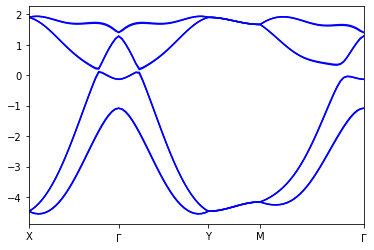

In [7]:
mod = model
k=[[0.5,0.],[0.,0.],[0.5,0],[0.5,0.5],[0.,0.]]
kvec,kdist,knode = mod.k_path(k,100)
evals = mod.solve_all(kvec)
fig, ax = plt.subplots()
for band in evals:
    ax.plot(kdist,band,c='blue')
# ax.plot(kdist,evals[1,:])
ax.set_xticks(knode)
ax.set_xticklabels(["X","$\Gamma$","Y","M","$\Gamma$"])
ax.set_xlim(knode[0],knode[-1])

----- k_path report begin ----------
real-space lattice vectors
 [[3.495   0.      0.     ]
 [0.      6.05352 0.     ]]
k-space metric tensor
 [[0.08187 0.     ]
 [0.      0.02729]]
internal coordinates of nodes
 [[0.5 0. ]
 [0.  0. ]
 [0.5 0. ]
 [0.5 0.5]
 [0.  0. ]]
list of segments:
  length = 0.14306  from  [0.5 0. ]  to  [0. 0.]
  length = 0.14306  from  [0. 0.]  to  [0.5 0. ]
  length =  0.0826  from  [0.5 0. ]  to  [0.5 0.5]
  length = 0.16519  from  [0.5 0.5]  to  [0. 0.]
node distance list: [0.      0.14306 0.28612 0.36872 0.53391]
node index list:    [ 0 27 53 68 99]
----- k_path report end ------------



(0.0, 0.5339128661571937)

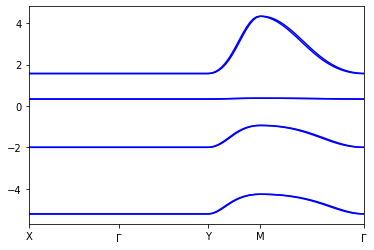

In [8]:
ymod = ymodel
k=[[0.5,0.],[0.,0.],[0.5,0],[0.5,0.5],[0.,0.]]
kvec,kdist,knode = ymod.k_path(k,100)
evals = ymod.solve_all(kvec)
fig, ax = plt.subplots()
for band in evals:
    ax.plot(kdist,band,c='blue')
# ax.plot(kdist,evals[1,:])
ax.set_xticks(knode)
ax.set_xticklabels(["X","$\Gamma$","Y","M","$\Gamma$"])
ax.set_xlim(knode[0],knode[-1])